***Parameter Definitions***

In [50]:
nx, ny, nz              = 32, 32, 8                    # Spatial Dimension
m                       = 16                             # Number of Patterns
dd_factor               = 2                             # Detector Downsampling Factor

Linearized Model

In [56]:
from libs.forward_lib.linearized_process import LinearizedModel
import torch
import numpy as np

LM = LinearizedModel()
LM.load_matrix(it = 130, is_original=False)
print(LM)

B, b = 31, 31
X = torch.load(f"./data/dataset/object/X_r_{B}.pt")[b]
# y_clean = torch.load(f"./data/dataset/measurement/Y_{B}.pt")[b]

X = X.cpu().numpy().reshape(32*32*8, 1)
# y_clean = y_clean.cpu().numpy().reshape(16*16*16, 1)
FM = LM.A.cpu().numpy()
y_clean = FM@X



def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB).reshape(16*16*16, 1)

Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 32.000um × 32.000um × 8.000um
Voxel Size 			: 1.0um × 1.0um × 1.0um
Original Shape 			: 32 × 32 × 8
DMD Patch Size 			: 2.0um × 2.0um
DMD Patterns 			: 16
# of Plane			: 1
Detector Pool size 		: 2×2
Computational Device 		: cuda




***Basic Reconstruction***


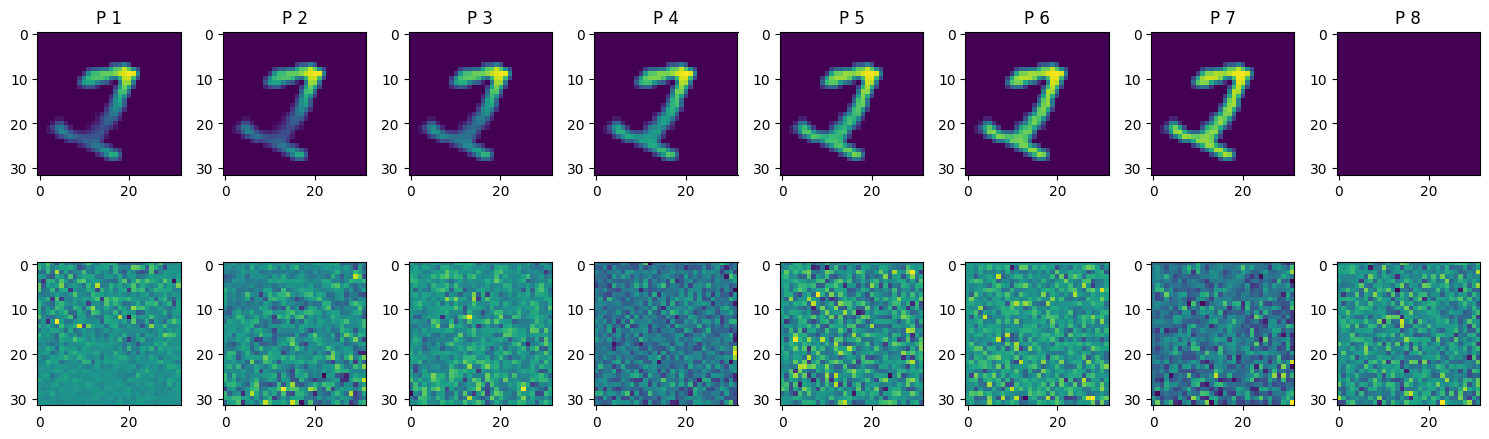

plane 1 | SSIM = 0.0291 | PSNR = -28.9890 dB
plane 2 | SSIM = 0.0293 | PSNR = 17.8191 dB
plane 3 | SSIM = 0.0337 | PSNR = 18.6227 dB
plane 4 | SSIM = 0.0476 | PSNR = 18.3672 dB
plane 5 | SSIM = 0.0123 | PSNR = 15.9240 dB
plane 6 | SSIM = 0.0433 | PSNR = 17.5681 dB
plane 7 | SSIM = 0.0299 | PSNR = 16.8426 dB
plane 8 | SSIM = 0.0214 | PSNR = 17.0398 dB


In [57]:
import libs.reconstruction_lib.twist_utils as utils
x_recons = torch.linalg.pinv(LM.A)@torch.tensor(y_noisy).to(LM.device).float()
ssim_values, psnr_values = utils.comparison2(X, x_recons.cpu().numpy().reshape(32*32*8,1), nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))

Run twist


Initial objective = 209893.17403408966, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Incrementing S = 256
Incrementing S = 512
Incrementing S = 1024
Incrementing S = 2048
Incrementing S = 4096
Incrementing S = 8192
Iteration = 2, objective = 39053.76503085769, nz = 7168, criterion = 813.9350400003251
Iteration = 3, objective = 18013.9696676715, nz = 7168, criterion = 538.7392315839955
Iteration = 4, objective = 13858.941844342593, nz = 7168, criterion = 230.65586874977728
Iteration = 5, objective = 6582.2917625657155, nz = 7168, criterion = 525.0509139517967
Iteration = 6, objective = 4555.92906005821, nz = 7168, criterion = 307.8506355539683
Iteration = 7, objective = 3809.282305047534, nz = 7168, criterion = 163.8846314699062
Iteration = 8, objective = 3226.521961199906, nz = 7168, criterion = 152.9842886875133
Iteration = 9, objective = 2791.2733929309197, nz = 7168, criterion 

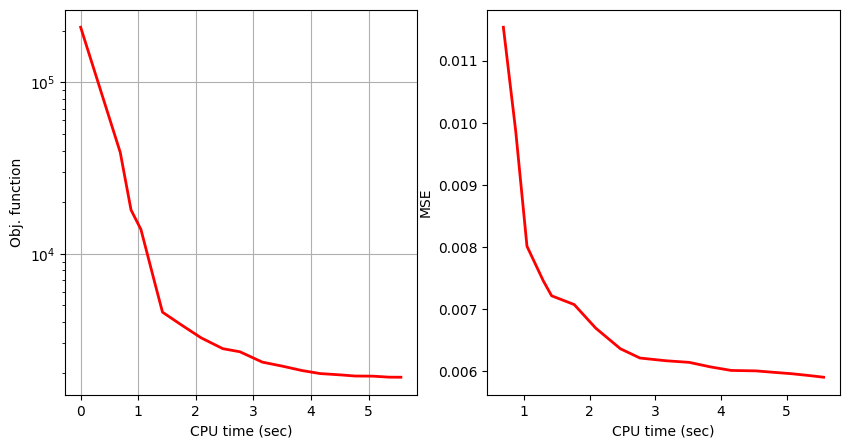

TwIST CPU time: 5.5625
MSE Loss: 5.9040e-03


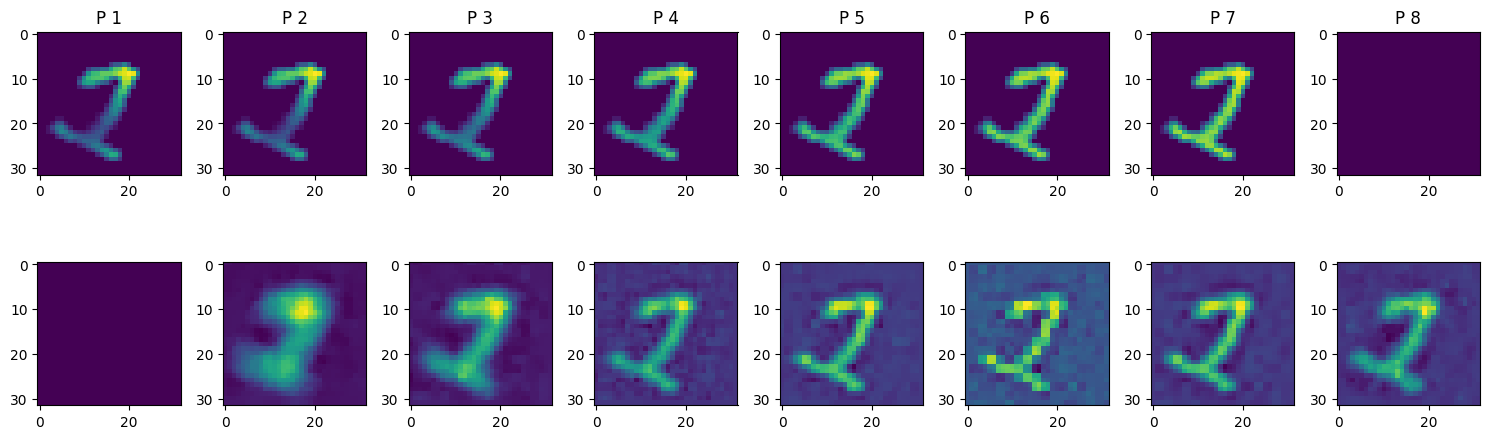

plane 1 | SSIM = nan | PSNR = -inf dB
plane 2 | SSIM = 0.3851 | PSNR = 14.9945 dB
plane 3 | SSIM = 0.5841 | PSNR = 15.8410 dB
plane 4 | SSIM = 0.6843 | PSNR = 24.1804 dB
plane 5 | SSIM = 0.3899 | PSNR = 8.9041 dB
plane 6 | SSIM = 0.4016 | PSNR = 15.0513 dB
plane 7 | SSIM = 0.7332 | PSNR = 23.7083 dB
plane 8 | SSIM = 0.1642 | PSNR = 14.9945 dB


In [61]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_noisy

# absAty = np.abs(utils.AT(y, FM, nx, ny, nz))
# tau = 1e-7*np.max(absAty) # Regularization parameter
tau = 1e-1 # Regularization parameter
Psi = 'TV' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'L1' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-1 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-3 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)

utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))